# Multilayer Perceptron Network

The development of artificial neural networks has been around almost since the beginning of the Articial Intelligence field. The figure below shows a little bit of its history.

<div style="text-align: center;"><img border="0"  src="neuralNetworksTimeline.png"/></div>
<div style="text-align: center;"><b>Fig. 1</b>. Timeline of neural networks, based on [1].</div>

First, lets setup our notebook with the libraries we will need.

In [2]:
from __future__ import division

import matplotlib
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import numpy as np
import random

%matplotlib inline

## Implementation

The following code implements a MLP network with the standard definition plus random shuffle of datapoints to prevent get stuck on local minima, further details on the Backpropagation algorithm can be found on [2].

In [26]:
class MLP:
    def __init__(self, number_of_neurons_per_layer, learning_rate, momentum_const=0.9):        
        self.number_of_inputs = number_of_neurons_per_layer[0]
        self.number_of_layers = number_of_neurons_per_layer.size
        self.number_of_hidden_layers = number_of_neurons_per_layer.size-1
        self.number_of_neurons_per_layer = number_of_neurons_per_layer
        self.learning_rate = learning_rate
        self.momentum_const = momentum_const
        self._randomly_initialize_connections()
        
        # Initializing feedforward auxiliary variables
        self._input_signals = np.empty(self.number_of_hidden_layers, dtype=object)
        self._output_signals = np.empty(self.number_of_hidden_layers, dtype=object)

    @staticmethod
    def sigmoid(x):
      return 1/(1+np.exp(-x))

    def _randomly_initialize_connections(self):
        self.bias = np.empty(self.number_of_hidden_layers, dtype=object)
        self.weights = np.empty(self.number_of_hidden_layers, dtype=object)
        
        number_of_inputs_current_layer = self.number_of_inputs
        for i in xrange(self.number_of_hidden_layers):
            number_of_inputs_next_layer = self.number_of_neurons_per_layer[i+1]            
            self.bias[i] = np.random.rand(1, number_of_inputs_next_layer)
            self.weights[i] = np.random.rand(number_of_inputs_current_layer, number_of_inputs_next_layer)
            number_of_inputs_current_layer = number_of_inputs_next_layer
            
    def feedforward(self, input_signal):
        self._input_signals[0] = input_signal
        self._output_signals[0] = MLP.sigmoid(np.dot(self._input_signals[0], self.weights[0]) + self.bias[0])
        for i in xrange(1,self.number_of_hidden_layers):
            self._input_signals[i] = self._output_signals[i-1]
            self._output_signals[i] = MLP.sigmoid(np.dot(self._input_signals[i], self.weights[i]) + self.bias[i])
        return self._output_signals[-1]
        
    def backpropagation(self, training_set, number_of_epochs):

        # Initializing auxiliary variables for backpropagation        
        local_gradients = np.empty(self.number_of_hidden_layers, dtype=object)
        delta_bias = np.empty(self.number_of_hidden_layers, dtype=object)
        delta_weights = np.empty(self.number_of_hidden_layers, dtype=object)
        
        self._randomly_initialize_connections()

        avg_squared_error = np.zeros(number_of_epochs)        
        number_of_patterns = training_set.shape[0]
        for i in xrange(number_of_epochs):    
            indices = np.arange(number_of_patterns)
            np.random.shuffle(indices)
            for j in indices:

                # Backwards propagation of errors

                # Feedforward
                self.feedforward(training_set[j,:-1,None].T)
                
                # Local gradient calculation for the output layer
                error = training_set[j,-1] - self._output_signals[-1]    
                sigmoid_derivative = np.multiply(self._output_signals[-1], 1-self._output_signals[-1])
                local_gradients[-1] = np.multiply(error, sigmoid_derivative)

                # Calculating delta weights and biases
                local_gradient = np.repeat(local_gradients[-1], self.number_of_neurons_per_layer[-2], axis=0)
                input_signal = np.repeat(self._input_signals[-1].T, local_gradients[-1].size, axis=1)                 
                delta_bias[-1] = self.learning_rate*local_gradients[-1]
                delta_weights[-1] = self.learning_rate*np.multiply(local_gradient, input_signal)
                
                # Local gradient calculation for all hidden layers
                for k in xrange(-2,-self.number_of_hidden_layers-1,-1): 
                    output_signal = self._output_signals[k]
                    sigmoid_derivative = np.multiply(output_signal, 1-output_signal)
                    local_gradients[k] = np.multiply(sigmoid_derivative, np.dot(self.weights[k+1], local_gradients[k+1].T).T)

                    # Calculating delta weights and biases
                    local_gradient = np.repeat(local_gradients[k], self.number_of_neurons_per_layer[k-1], axis=0)
                    input_signal = np.repeat(self._input_signals[k].T, local_gradients[k].size, axis=1)    
                    delta_bias[k] = self.learning_rate*local_gradients[k]
                    delta_weights[k] = self.learning_rate*np.multiply(local_gradient, input_signal)

                # Update weights and biases
                for k in xrange(self.number_of_hidden_layers):
                    self.bias[k] += delta_bias[k]
                    self.weights[k] += delta_weights[k]
                    
                avg_squared_error[i] += np.power(error,2)/2
            avg_squared_error[i] /= number_of_patterns
            
        return avg_squared_error

## XOR training dataset

The importance of training an XOR function proved to be an obstacle that lasted more than fifteen years starting in 1969. So lets create our jitter XOR dataset to train our Multilayer Perceptron (MLP) network.

In [27]:
# Creating the training data
np.random.seed(15)
number_training_data = 400

negative_indices = np.arange(200);
positive_indices = np.arange(200,400);

covariance = 0.09
training_set = np.random.multivariate_normal([-1,-1],covariance*np.eye(2),number_training_data)
training_set[100:200,] += 2.5
training_set[200:300,0] += 2.5
training_set[300:400,1] += 2.5

training_target = np.ones((number_training_data))
training_target[negative_indices] = 0
training_set = np.column_stack((training_set, training_target))

Now lets plot our XOR in anger function

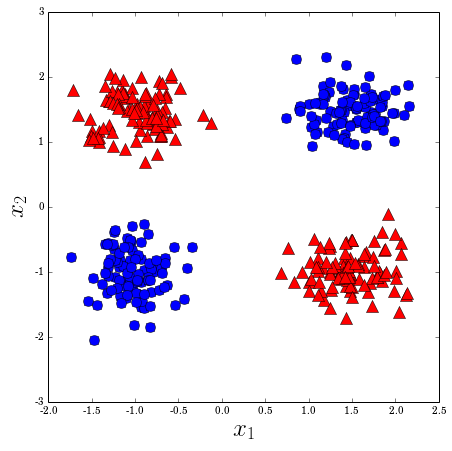

In [7]:
fig = plt.figure(figsize=(7,7))
plt.plot(training_set[negative_indices,0],training_set[negative_indices,1],'b',marker='o',markersize=10,linestyle='None');
plt.plot(training_set[positive_indices,0],training_set[positive_indices,1],'r',marker='^',markersize=12,linestyle='None');
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.xlabel(r'$x_1$',fontsize=25)
plt.ylabel(r'$x_2$',fontsize=25)

## Solving the XOR function toy problem

The architecture that we will use consists in 2 unit layer input, a hidden layer with 3 units, and 1 unit in the output. The architecture is shown in the figure below.

<div style="text-align: center;"><img border="0"  src="xorMLP2x3x1.png"/></div>
<div style="text-align: center;"><b>Fig. 2</b>. MLP network to solve the XOR function.</div>

Lets define our neural network with a learning rate equal to 0.15 and train it during 200 epochs.

In [29]:
np.random.seed(12)
number_of_epochs = 200
learning_rate = 0.15
mlp = MLP(np.array([2, 3, 1]), learning_rate)

avg_square_error = mlp.backpropagation(training_set,number_of_epochs)

Now lets plot our average error energy against the epoch

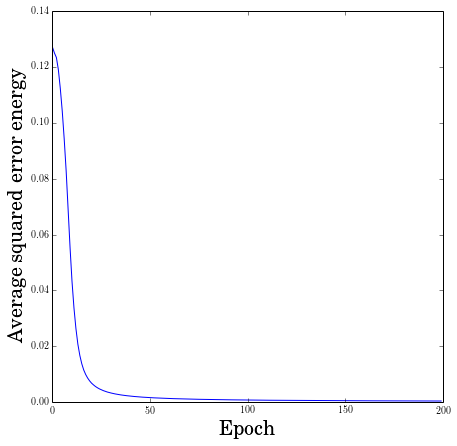

In [30]:
fig = plt.figure(figsize=(7,7))
plt.plot(avg_square_error);
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.xlabel(r'Epoch',fontsize=20)
plt.ylabel(r'Average squared error energy',fontsize=20)

Finally, lets plot the result of our trained network in our XOR in anger dataset. But in order to visualize the decision boundaries, first we need to create a meshgrid.

In [31]:
# Creating the meshgrid for the decision boundaries level curves
delta = 0.00625
lower_left_corner = np.min(training_set[:,:-1])-20*delta
upper_right_corner = np.max(training_set[:,:-1])+20*delta
x1 = np.arange(lower_left_corner,upper_right_corner, delta)
x1, x2 = np.meshgrid(x1, x1)

y231 = np.zeros(shape=np.shape(x1))
for i in xrange(np.shape(x1)[0]):
    for j in xrange(np.shape(x1)[1]):
        y231[i,j] = mlp.feedforward(np.array([[x1[i,j]],[x2[i,j]]]).T)
        
mlp231 = np.zeros(shape=np.shape(training_target))
for i in xrange(training_target.shape[0]):
    mlp231[i] = mlp.feedforward(training_set[i,:-1,None].T)

# Creating array indices of predicted values    
mlp231_prediction = np.round(mlp231)==training_target
true_pred_indices = np.nonzero(mlp231_prediction==True)[0]

trueNegIndices = np.intersect1d(negative_indices, true_pred_indices);
truePosIndices = np.intersect1d(positive_indices, true_pred_indices);
falseNegIndices = np.setdiff1d(positive_indices, truePosIndices);
falsePosIndices = np.setdiff1d(negative_indices, trueNegIndices);

Now the trivial part is to plot the results

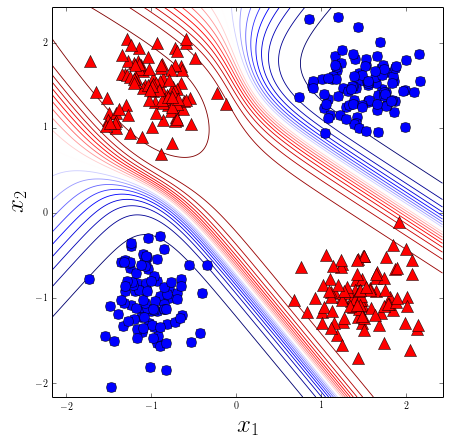

In [32]:
fig = plt.figure(figsize=(7,7))
levels = np.arange(-0.010, 1.010, 0.05)
plt.contour(y231, levels, origin='lower',linewidths=0.85, cmap=plt.get_cmap('seismic'), extent=(lower_left_corner,upper_right_corner,lower_left_corner,upper_right_corner))
CS = plt.contour(y231, [0], linewidths=1.25, cmap=plt.get_cmap('seismic'), extent=(lower_left_corner,upper_right_corner,lower_left_corner,upper_right_corner))

plt.plot(training_set[trueNegIndices,0],training_set[trueNegIndices,1],'b',marker='o',markersize=10,linestyle='None');
plt.plot(training_set[truePosIndices,0],training_set[truePosIndices,1],'r',marker='^',markersize=12,linestyle='None');
plt.plot(training_set[falseNegIndices,0],training_set[falseNegIndices,1],'b',marker='^',markersize=12,linestyle='None');
plt.plot(training_set[falsePosIndices,0],training_set[falsePosIndices,1],'r',marker='o',markersize=10,linestyle='None');

plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.xlabel(r'$x_1$',fontsize=25)
plt.ylabel(r'$x_2$',fontsize=25)

## Bibliography

[1] Yoshua Bengio, Ian J. Goodfellow, and Aaron Courville, *Deep Learning*. Book in preparation for MIT Press, 2015.

[2] Laurene Fausett, *Fundamentals of Neural Networks: Architectures, Algorithms, and Applications*. Prentice-Hall, 1994.

In [ ]:
# TODO: Regularize Backpropagation

# TODO: Add momentum 

# TODO: Average Squared Error must be a vector and not a scalar

# TODO: Make only one Backpropagation function

# TODO: Fix the Decision Boundary limit labels

# TODO: Add changing learning parameter